In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives_2d

Equation:

$$
0 = \max_{e} \min_{h_2} b\left[\delta \eta \log e - \delta(1-\eta)y -\frac{y^2}{2}\right] -\ell e + \frac{\partial \phi}{\partial y}(y, b;\ell) e - \frac{\partial \phi}{\partial b}(y, b;\ell) \delta b
$$

FOC of $e$ gives :

$$
e^* = \frac{b \delta \eta}{\ell - \frac{\partial \phi}{\partial y}(y, b; \ell)}
$$

In [21]:
def false_transient_one_iteration(stateSpace, A, B_b, B_y, C_bb, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_b.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_bb.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(b_grid, y_grid, ℓ, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    τ, η, ξ_m, δ, η, μ_2, ρ, σ_2 = model_paras

    Δ_b = b_grid[1] - b_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (b_mat, y_mat) = np.meshgrid(b_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([b_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = np.zeros_like(b_mat)
#         v0 = -δ*η*y_mat

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_db = compute_derivatives_2d(v0, 0, 1, Δ_b)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        e = b_mat*δ*η / (ℓ-v0_dy)
#         e[e<=0] = 1e-5

        A = np.zeros_like(b_mat)
        B_b = -(δ*b_mat)
        B_y = e
        C_bb = np.zeros_like(b_mat)
        C_yy = np.zeros_like(b_mat)
#         D = b_mat*(δ*η*np.log(e) - δ*(1-η)*y_mat - y_mat**2/2) - ℓ*e
        D = b_mat*(δ*η*np.log(e) - δ*(1-η)*y_mat) - ℓ*e

        res = false_transient_one_iteration(stateSpace, A, B_b, B_y, C_bb, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = B_b*v0_db + B_y*v0_dy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
#         error = rhs_error

        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0

In [22]:
# Model parameters
median = 1.75/1000
γ = .018
τ = median * γ
η = .032
ξ_m = .00256
δ = .01
η = .032

μ_2 = 1.
ρ = .5
σ_2 = np.sqrt((.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

model_paras = (τ, η, ξ_m, δ, η, μ_2, ρ, σ_2)

# Grid setting
n_b = 200
b_min = 1e-2
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

n_y = 200
y_min = 1e-2
y_max = 3000.
y_grid = np.linspace(y_min, y_max, n_y)

# ℓ setting
log_ell_grid = np.linspace(-13, -5, 200)
ℓ_step = 1e-7

In [23]:
# ψs = []
# ψs_next = []

# for i, ℓ in enumerate(np.exp(log_ell_grid)):
#     print(i)
#     max_iter = 1000
#     \ell
#     ψ = false_transient(z_grid, b_grid, y_grid, ℓ, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
#     ψ_next = false_transient(z_grid, b_grid, y_grid, ℓ+ℓ_step, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
#     ψs.append(ψ)
#     ψs_next.append(ψ_next)

In [24]:
ψ = false_transient(b_grid, y_grid, 1e-4, model_paras=model_paras, v0=None, ϵ=.3, tol=1e-8, max_iter=100_000)

Iteration 1: LHS Error: 28.962299363494726; RHS Error 29.03994779174086
Iteration 2: LHS Error: 28.86782731032295; RHS Error 28.954122239879624
Iteration 3: LHS Error: 28.781546971098944; RHS Error 28.86773487098599
Iteration 4: LHS Error: 28.695536229967793; RHS Error 28.78151785504153
Iteration 5: LHS Error: 28.609771648711586; RHS Error 28.695522081692175
Iteration 6: LHS Error: 28.524253697970703; RHS Error 28.60976330891321
Iteration 7: LHS Error: 28.438983888571226; RHS Error 28.524248208345536
Iteration 8: LHS Error: 28.353963220084545; RHS Error 28.438980005892645
Iteration 9: LHS Error: 28.269192204560152; RHS Error 28.35396033162085
Iteration 10: LHS Error: 28.184671007386395; RHS Error 28.26918997359541
Iteration 11: LHS Error: 28.100399556419312; RHS Error 28.184669233627602
Iteration 12: LHS Error: 28.016377615414996; RHS Error 28.100398113303605
Iteration 13: LHS Error: 27.932604825598446; RHS Error 28.016376419067367
Iteration 14: LHS Error: 27.849080764619128; RHS Error

Iteration 118: LHS Error: 20.395059177093724; RHS Error 20.456242036544808
Iteration 119: LHS Error: 20.33405932511452; RHS Error 20.395059208896775
Iteration 120: LHS Error: 20.273241902018526; RHS Error 20.334059356959898
Iteration 121: LHS Error: 20.21260636259361; RHS Error 20.273241933899634
Iteration 122: LHS Error: 20.152152163249944; RHS Error 20.21260639450671
Iteration 123: LHS Error: 20.09187876201433; RHS Error 20.152152195192414
Iteration 124: LHS Error: 20.031785618519585; RHS Error 20.09187879398184
Iteration 125: LHS Error: 19.971872194006437; RHS Error 20.031785650510024
Iteration 126: LHS Error: 19.91213795131747; RHS Error 19.97187222601677
Iteration 127: LHS Error: 19.85258235488535; RHS Error 19.912137983341417
Iteration 128: LHS Error: 19.793204870738542; RHS Error 19.85258238692127
Iteration 129: LHS Error: 19.73400496649712; RHS Error 19.79320490278613
Iteration 130: LHS Error: 19.674982111355728; RHS Error 19.734004998550553
Iteration 131: LHS Error: 19.6161357

Iteration 232: LHS Error: 14.495155762309272; RHS Error 14.538640242723467
Iteration 233: LHS Error: 14.451801345978765; RHS Error 14.495155770132923
Iteration 234: LHS Error: 14.408576597044583; RHS Error 14.451801353795979
Iteration 235: LHS Error: 14.365481127802013; RHS Error 14.408576604851447
Iteration 236: LHS Error: 14.322514551704444; RHS Error 14.36548113559701
Iteration 237: LHS Error: 14.279676483364863; RHS Error 14.322514559489688
Iteration 238: LHS Error: 14.23696653854601; RHS Error 14.279676491141736
Iteration 239: LHS Error: 14.1943843341528; RHS Error 14.236966546310601
Iteration 240: LHS Error: 14.151929488238391; RHS Error 14.194384341907613
Iteration 241: LHS Error: 14.10960161999962; RHS Error 14.151929495983824
Iteration 242: LHS Error: 14.067400349764133; RHS Error 14.109601627732323
Iteration 243: LHS Error: 14.025325299002514; RHS Error 14.067400357486381
Iteration 244: LHS Error: 13.983376090307805; RHS Error 14.025325306711272
Iteration 245: LHS Error: 13.9

Iteration 345: LHS Error: 10.332856199432475; RHS Error 10.363854228911283
Iteration 346: LHS Error: 10.301950889536329; RHS Error 10.33285620564768
Iteration 347: LHS Error: 10.271138015711283; RHS Error 10.301950895736532
Iteration 348: LHS Error: 10.240417301514148; RHS Error 10.271138021900097
Iteration 349: LHS Error: 10.209788471311944; RHS Error 10.240417307686815
Iteration 350: LHS Error: 10.179251250305395; RHS Error 10.209788477469967
Iteration 351: LHS Error: 10.148805364514526; RHS Error 10.179251256446296
Iteration 352: LHS Error: 10.118450540778667; RHS Error 10.148805370640577
Iteration 353: LHS Error: 10.08818650675797; RHS Error 10.118450546890553
Iteration 354: LHS Error: 10.058012990915966; RHS Error 10.08818651285009
Iteration 355: LHS Error: 10.02792972253701; RHS Error 10.05801299699198
Iteration 356: LHS Error: 9.997936431708847; RHS Error 10.027929728596021
Iteration 357: LHS Error: 9.968032849336245; RHS Error 9.99793643775817
Iteration 358: LHS Error: 9.938218

Iteration 459: LHS Error: 7.343725588436125; RHS Error 7.365756486177272
Iteration 460: LHS Error: 7.321760631413478; RHS Error 7.343725634792115
Iteration 461: LHS Error: 7.299861371564779; RHS Error 7.321760677634245
Iteration 462: LHS Error: 7.278027612425528; RHS Error 7.299861417648312
Iteration 463: LHS Error: 7.256259158090567; RHS Error 7.278027658363957
Iteration 464: LHS Error: 7.234555813267131; RHS Error 7.256259203899415
Iteration 465: LHS Error: 7.212917383224825; RHS Error 7.234555858940567
Iteration 466: LHS Error: 7.191343673792593; RHS Error 7.212917428755496
Iteration 467: LHS Error: 7.16983449141632; RHS Error 7.191343719197285
Iteration 468: LHS Error: 7.148389643070914; RHS Error 7.169834536679289
Iteration 469: LHS Error: 7.127008936331549; RHS Error 7.1483896881989395
Iteration 470: LHS Error: 7.10569217934335; RHS Error 7.127008981327663
Iteration 471: LHS Error: 7.084439180810781; RHS Error 7.105692224202681
Iteration 472: LHS Error: 7.063249750008254; RHS Err

Iteration 577: LHS Error: 5.157135396034391; RHS Error 5.172606626661356
Iteration 578: LHS Error: 5.141710472359288; RHS Error 5.157135428628795
Iteration 579: LHS Error: 5.1263316845370355; RHS Error 5.141710504851989
Iteration 580: LHS Error: 5.110998894583645; RHS Error 5.126331716932992
Iteration 581: LHS Error: 5.095711964930464; RHS Error 5.110998926886079
Iteration 582: LHS Error: 5.0804707583984055; RHS Error 5.095711997128667
Iteration 583: LHS Error: 5.065275138244942; RHS Error 5.080470790504993
Iteration 584: LHS Error: 5.0501249681216605; RHS Error 5.065275170256918
Iteration 585: LHS Error: 5.035020112098513; RHS Error 5.050125000041291
Iteration 586: LHS Error: 5.019960434628956; RHS Error 5.0350201439153075
Iteration 587: LHS Error: 5.0049458005954275; RHS Error 5.019960466355702
Iteration 588: LHS Error: 4.98997607527599; RHS Error 5.004945832229534
Iteration 589: LHS Error: 4.975051124345859; RHS Error 4.989976106814247
Iteration 590: LHS Error: 4.960170813883451; RH

Iteration 690: LHS Error: 3.67625046040151; RHS Error 3.687279271093171
Iteration 691: LHS Error: 3.665254863535665; RHS Error 3.6762506884438295
Iteration 692: LHS Error: 3.65429215290078; RHS Error 3.665255090893229
Iteration 693: LHS Error: 3.6433622299925146; RHS Error 3.6542923795818183
Iteration 694: LHS Error: 3.6324649966127254; RHS Error 3.6433624559891946
Iteration 695: LHS Error: 3.6216003549301; RHS Error 3.63246522194412
Iteration 696: LHS Error: 3.610768207398299; RHS Error 3.621600579587941
Iteration 697: LHS Error: 3.5999684567862764; RHS Error 3.6107684313838
Iteration 698: LHS Error: 3.5892010061600863; RHS Error 3.599968680099167
Iteration 699: LHS Error: 3.5784657588874325; RHS Error 3.5892012288059476
Iteration 700: LHS Error: 3.5677626186103835; RHS Error 3.578465980863033
Iteration 701: LHS Error: 3.5570914892787187; RHS Error 3.5677628399245656
Iteration 702: LHS Error: 3.5464522751196155; RHS Error 3.5570917099344364
Iteration 703: LHS Error: 3.535844880663414;

Iteration 806: LHS Error: 2.5971601006055307; RHS Error 2.6049516477795365
Iteration 807: LHS Error: 2.5893920186338923; RHS Error 2.5971602617303837
Iteration 808: LHS Error: 2.581647170559336; RHS Error 2.5893921792737054
Iteration 809: LHS Error: 2.5739254868994976; RHS Error 2.581647330718713
Iteration 810: LHS Error: 2.5662268983781664; RHS Error 2.573925646578438
Iteration 811: LHS Error: 2.5585513359161878; RHS Error 2.5662270575779793
Iteration 812: LHS Error: 2.5508987306648123; RHS Error 2.558551494642643
Iteration 813: LHS Error: 2.5432690139617384; RHS Error 2.5508988889124815
Iteration 814: LHS Error: 2.535662117353847; RHS Error 2.5432691717369416
Iteration 815: LHS Error: 2.5280779726047817; RHS Error 2.535662274661938
Iteration 816: LHS Error: 2.520516511664634; RHS Error 2.528078129437244
Iteration 817: LHS Error: 2.512977666695709; RHS Error 2.5205166680265414
Iteration 818: LHS Error: 2.505461370081624; RHS Error 2.5129778226018935
Iteration 819: LHS Error: 2.4979675

Iteration 921: LHS Error: 1.8403194766157565; RHS Error 1.8458404758899611
Iteration 922: LHS Error: 1.8348151047969927; RHS Error 1.8403195907856293
Iteration 923: LHS Error: 1.829327196525507; RHS Error 1.834815218629192
Iteration 924: LHS Error: 1.8238557025506452; RHS Error 1.8293273100194654
Iteration 925: LHS Error: 1.8184005737809155; RHS Error 1.8238558157097309
Iteration 926: LHS Error: 1.8129617612430593; RHS Error 1.8184006865949698
Iteration 927: LHS Error: 1.807539216145718; RHS Error 1.8129618737255448
Iteration 928: LHS Error: 1.8021328898142506; RHS Error 1.807539328288005
Iteration 929: LHS Error: 1.7967427337483364; RHS Error 1.8021330016261494
Iteration 930: LHS Error: 1.791368699555278; RHS Error 1.7967428452171923
Iteration 931: LHS Error: 1.7860107390273092; RHS Error 1.7913688106965147
Iteration 932: LHS Error: 1.7806688040718655; RHS Error 1.7860108498311114
Iteration 933: LHS Error: 1.775342846744934; RHS Error 1.7806689145406338
Iteration 934: LHS Error: 1.770

Iteration 1034: LHS Error: 1.3118664938034879; RHS Error 1.3158022467030897
Iteration 1035: LHS Error: 1.3079426906294127; RHS Error 1.3118666730089075
Iteration 1036: LHS Error: 1.304030622385047; RHS Error 1.3079428692973138
Iteration 1037: LHS Error: 1.300130254104867; RHS Error 1.304030800507089
Iteration 1038: LHS Error: 1.2962415509628045; RHS Error 1.3001304317004276
Iteration 1039: LHS Error: 1.2923644781979724; RHS Error 1.296241728022693
Iteration 1040: LHS Error: 1.2884990011752961; RHS Error 1.2923646547307683
Iteration 1041: LHS Error: 1.2846450853400408; RHS Error 1.2884991771793537
Iteration 1042: LHS Error: 1.2808026962541894; RHS Error 1.2846452608227779
Iteration 1043: LHS Error: 1.2769717995570318; RHS Error 1.2808028712085857
Iteration 1044: LHS Error: 1.2731523609909345; RHS Error 1.2769719739848888
Iteration 1045: LHS Error: 1.2693443463983083; RHS Error 1.2731525349003583
Iteration 1046: LHS Error: 1.2655477217170605; RHS Error 1.2693445197913888
Iteration 1047: 

Iteration 1143: LHS Error: 0.9464320229941829; RHS Error 0.9492714187041891
Iteration 1144: LHS Error: 0.9436012489049972; RHS Error 0.9464321522761878
Iteration 1145: LHS Error: 0.9407789413792974; RHS Error 0.9436013778004302
Iteration 1146: LHS Error: 0.9379650750906876; RHS Error 0.9407790698838632
Iteration 1147: LHS Error: 0.9351596248143323; RHS Error 0.9379652032175478
Iteration 1148: LHS Error: 0.9323625653754183; RHS Error 0.9351597525555846
Iteration 1149: LHS Error: 0.9295738716885656; RHS Error 0.9323626927334665
Iteration 1150: LHS Error: 0.9267935187381227; RHS Error 0.9295739986634253
Iteration 1151: LHS Error: 0.9240214815872605; RHS Error 0.9267936453363355
Iteration 1152: LHS Error: 0.9212577353749415; RHS Error 0.9240216078052086
Iteration 1153: LHS Error: 0.9185022553144033; RHS Error 0.92125786121996
Iteration 1154: LHS Error: 0.9157550166795166; RHS Error 0.9185023807762143
Iteration 1155: LHS Error: 0.9130159948396492; RHS Error 0.9157551417710366
Iteration 1156

Iteration 1258: LHS Error: 0.6706312428847621; RHS Error 0.6726431980436018
Iteration 1259: LHS Error: 0.6686253971611222; RHS Error 0.6706313344932369
Iteration 1260: LHS Error: 0.6666255509874949; RHS Error 0.6686254884973266
Iteration 1261: LHS Error: 0.6646316864165177; RHS Error 0.6666256420494854
Iteration 1262: LHS Error: 0.6626437855447875; RHS Error 0.664631777201798
Iteration 1263: LHS Error: 0.6606618305355976; RHS Error 0.6626438760630364
Iteration 1264: LHS Error: 0.6586858036052945; RHS Error 0.6606619207858415
Iteration 1265: LHS Error: 0.6567156870050894; RHS Error 0.658685893576795
Iteration 1266: LHS Error: 0.6547514630559211; RHS Error 0.6567157767073688
Iteration 1267: LHS Error: 0.6527931141348139; RHS Error 0.6547515524920087
Iteration 1268: LHS Error: 0.6508406226551718; RHS Error 0.6527932033018047
Iteration 1269: LHS Error: 0.6488939711046745; RHS Error 0.6508407115618162
Iteration 1270: LHS Error: 0.6469531419967705; RHS Error 0.6488940597409503
Iteration 1271

Iteration 1367: LHS Error: 0.4838205422781054; RHS Error 0.4852719373434198
Iteration 1368: LHS Error: 0.48237342590406723; RHS Error 0.48382048151834667
Iteration 1369: LHS Error: 0.480930636328291; RHS Error 0.48237336533379604
Iteration 1370: LHS Error: 0.4794921607193222; RHS Error 0.4809305759314242
Iteration 1371: LHS Error: 0.4780579863139186; RHS Error 0.4794921005031938
Iteration 1372: LHS Error: 0.4766281003791543; RHS Error 0.47805792627852384
Iteration 1373: LHS Error: 0.47520249021242006; RHS Error 0.47662804052340846
Iteration 1374: LHS Error: 0.4737811431611287; RHS Error 0.47520243053948263
Iteration 1375: LHS Error: 0.47236404658936715; RHS Error 0.4737810836631269
Iteration 1376: LHS Error: 0.47095118789760215; RHS Error 0.4723639872645329
Iteration 1377: LHS Error: 0.46954255452268023; RHS Error 0.4709511287504533
Iteration 1378: LHS Error: 0.46813813394843845; RHS Error 0.46954249556056027
Iteration 1379: LHS Error: 0.4667379136632614; RHS Error 0.46813807515827577


Iteration 1479: LHS Error: 0.34592418295081495; RHS Error 0.34696190102846103
Iteration 1480: LHS Error: 0.34488952497516345; RHS Error 0.3459241395165229
Iteration 1481: LHS Error: 0.34385796137788327; RHS Error 0.34488948166523414
Iteration 1482: LHS Error: 0.3428294829094133; RHS Error 0.34385791819580547
Iteration 1483: LHS Error: 0.3418040803474772; RHS Error 0.34282943985958525
Iteration 1484: LHS Error: 0.3407817444895045; RHS Error 0.34180403742440646
Iteration 1485: LHS Error: 0.33976246616627276; RHS Error 0.3407817016946453
Iteration 1486: LHS Error: 0.338746236238876; RHS Error 0.3397624235011847
Iteration 1487: LHS Error: 0.3377330455865983; RHS Error 0.33874619369959547
Iteration 1488: LHS Error: 0.3367228851281349; RHS Error 0.337733003176524
Iteration 1489: LHS Error: 0.3357157458003712; RHS Error 0.33672284284421394
Iteration 1490: LHS Error: 0.3347116185750565; RHS Error 0.3357157036441514
Iteration 1491: LHS Error: 0.3337104944436457; RHS Error 0.33471157654250305
It

Iteration 1593: LHS Error: 0.24585296540256726; RHS Error 0.24659048279360718
Iteration 1594: LHS Error: 0.24511762323678948; RHS Error 0.24585293452628676
Iteration 1595: LHS Error: 0.24438448065969473; RHS Error 0.24511759245353204
Iteration 1596: LHS Error: 0.24365353109715215; RHS Error 0.24438444997480246
Iteration 1597: LHS Error: 0.2429247679871575; RHS Error 0.24365350050232948
Iteration 1598: LHS Error: 0.2421981847828647; RHS Error 0.24292473748127819
Iteration 1599: LHS Error: 0.2414737749586493; RHS Error 0.24219815436591574
Iteration 1600: LHS Error: 0.24075153202375077; RHS Error 0.24147374463614213
Iteration 1601: LHS Error: 0.240031449475282; RHS Error 0.24075150178554594
Iteration 1602: LHS Error: 0.23931352087250465; RHS Error 0.240031419338802
Iteration 1603: LHS Error: 0.23859773975497472; RHS Error 0.23931349082059228
Iteration 1604: LHS Error: 0.23788409969862795; RHS Error 0.23859770979304784
Iteration 1605: LHS Error: 0.23717259429455834; RHS Error 0.23788406982

Iteration 1705: LHS Error: 0.17578222687461675; RHS Error 0.17630950316634042
Iteration 1706: LHS Error: 0.17525647118266838; RHS Error 0.17578217253343453
Iteration 1707: LHS Error: 0.1747322859500855; RHS Error 0.17525641700574468
Iteration 1708: LHS Error: 0.17420966655966671; RHS Error 0.17473223193611176
Iteration 1709: LHS Error: 0.17368860841391628; RHS Error 0.1742096127084345
Iteration 1710: LHS Error: 0.17316910694868665; RHS Error 0.17368855472856026
Iteration 1711: LHS Error: 0.17265115759831437; RHS Error 0.17316905342061872
Iteration 1712: LHS Error: 0.17213475583200005; RHS Error 0.17265110423250363
Iteration 1713: LHS Error: 0.17161989712500753; RHS Error 0.17213470262306885
Iteration 1714: LHS Error: 0.17110657697079054; RHS Error 0.17161984407495723
Iteration 1715: LHS Error: 0.1705947908764453; RHS Error 0.17110652407993143
Iteration 1716: LHS Error: 0.17008453435664705; RHS Error 0.1705947381425581
Iteration 1717: LHS Error: 0.1695758029427452; RHS Error 0.170084481

Iteration 1814: LHS Error: 0.12681603660439578; RHS Error 0.12719643576649275
Iteration 1815: LHS Error: 0.12643673584534554; RHS Error 0.1268159974053269
Iteration 1816: LHS Error: 0.12605856939292912; RHS Error 0.1264366967604289
Iteration 1817: LHS Error: 0.12568153384715214; RHS Error 0.1260585304250057
Iteration 1818: LHS Error: 0.12530562581711518; RHS Error 0.12568149499232106
Iteration 1819: LHS Error: 0.12493084193162456; RHS Error 0.12530558708208872
Iteration 1820: LHS Error: 0.12455717881039163; RHS Error 0.1249308033094998
Iteration 1821: LHS Error: 0.12418463310799174; RHS Error 0.12455714030798504
Iteration 1822: LHS Error: 0.12381320146384193; RHS Error 0.12418459471558663
Iteration 1823: LHS Error: 0.12344288055373909; RHS Error 0.12381316318950653
Iteration 1824: LHS Error: 0.1230736670428693; RHS Error 0.12344284239062375
Iteration 1825: LHS Error: 0.12270555761157691; RHS Error 0.12307362899169405
Iteration 1826: LHS Error: 0.12233854896597526; RHS Error 0.122705519

Iteration 1920: LHS Error: 0.09231550651747966; RHS Error 0.09259242912881405
Iteration 1921: LHS Error: 0.09203938375321741; RHS Error 0.09231547797974571
Iteration 1922: LHS Error: 0.09176408698143254; RHS Error 0.09203935529976448
Iteration 1923: LHS Error: 0.09148961373739439; RHS Error 0.09176405861263248
Iteration 1924: LHS Error: 0.09121596155182488; RHS Error 0.09148958544943753
Iteration 1925: LHS Error: 0.09094312799030983; RHS Error 0.09121593335494893
Iteration 1926: LHS Error: 0.09067111058963444; RHS Error 0.09094309987121818
Iteration 1927: LHS Error: 0.09039990692599531; RHS Error 0.09067108256132528
Iteration 1928: LHS Error: 0.09012951455588336; RHS Error 0.09039987897643087
Iteration 1929: LHS Error: 0.08985993106307433; RHS Error 0.09012948669242604
Iteration 1930: LHS Error: 0.08959115403285978; RHS Error 0.0898599032824201
Iteration 1931: LHS Error: 0.08932318103992051; RHS Error 0.08959112633050736
Iteration 1932: LHS Error: 0.08905600970592786; RHS Error 0.08932

Iteration 2027: LHS Error: 0.06700022353318977; RHS Error 0.06720146614389222
Iteration 2028: LHS Error: 0.06679985905672463; RHS Error 0.06700049843880507
Iteration 2029: LHS Error: 0.06660009487859497; RHS Error 0.0668001331394592
Iteration 2030: LHS Error: 0.06640092888725728; RHS Error 0.06660036814897197
Iteration 2031: LHS Error: 0.06620235892417745; RHS Error 0.06640120132655625
Iteration 2032: LHS Error: 0.06600438288539105; RHS Error 0.06620263055612341
Iteration 2033: LHS Error: 0.0658069986548071; RHS Error 0.06600465370511799
Iteration 2034: LHS Error: 0.06561020415726186; RHS Error 0.06580726866477349
Iteration 2035: LHS Error: 0.06541399733881312; RHS Error 0.06561047335463499
Iteration 2036: LHS Error: 0.06521837620463582; RHS Error 0.065414265735388
Iteration 2037: LHS Error: 0.06502333879022142; RHS Error 0.06521864380064102
Iteration 2038: LHS Error: 0.06482888317047279; RHS Error 0.0650236055823683
Iteration 2039: LHS Error: 0.06463500747031503; RHS Error 0.064829149

Iteration 2134: LHS Error: 0.04862733777220759; RHS Error 0.04877341008334213
Iteration 2135: LHS Error: 0.04848190204484126; RHS Error 0.04862753728588132
Iteration 2136: LHS Error: 0.04833690148188907; RHS Error 0.04848210096615446
Iteration 2137: LHS Error: 0.048192334760036225; RHS Error 0.04833709980331946
Iteration 2138: LHS Error: 0.048048200572641996; RHS Error 0.04819253248658839
Iteration 2139: LHS Error: 0.04790449761912896; RHS Error 0.04804839770882907
Iteration 2140: LHS Error: 0.04776122459285641; RHS Error 0.04790469416565557
Iteration 2141: LHS Error: 0.04761838020840514; RHS Error 0.04776142055816024
Iteration 2142: LHS Error: 0.04747596316216611; RHS Error 0.04761857558468918
Iteration 2143: LHS Error: 0.047333972165688465; RHS Error 0.04747615795273674
Iteration 2144: LHS Error: 0.047192405941132165; RHS Error 0.047334166377122955
Iteration 2145: LHS Error: 0.04705126320307803; RHS Error 0.04719259957081334
Iteration 2146: LHS Error: 0.04691054267671765; RHS Error 0

Iteration 2241: LHS Error: 0.03529274733258111; RHS Error 0.0353987761339809
Iteration 2242: LHS Error: 0.035187180324101064; RHS Error 0.03529289212864484
Iteration 2243: LHS Error: 0.03508192894211486; RHS Error 0.035187324692291355
Iteration 2244: LHS Error: 0.034976992231653035; RHS Error 0.035082072872445025
Iteration 2245: LHS Error: 0.03487236926503101; RHS Error 0.034977135733100795
Iteration 2246: LHS Error: 0.034768059114564195; RHS Error 0.03487251234189159
Iteration 2247: LHS Error: 0.03466406082983061; RHS Error 0.03476820175640327
Iteration 2248: LHS Error: 0.03456037350133556; RHS Error 0.03466420305068141
Iteration 2249: LHS Error: 0.034456996193815335; RHS Error 0.03456051529326842
Iteration 2250: LHS Error: 0.03435392797806951; RHS Error 0.034457137558213446
Iteration 2251: LHS Error: 0.03425116794915084; RHS Error 0.034354068925036785
Iteration 2252: LHS Error: 0.03414871517785893; RHS Error 0.03425130847234925
Iteration 2253: LHS Error: 0.03404656874711994; RHS Erro

Iteration 2351: LHS Error: 0.025384793076833983; RHS Error 0.025461053580002613
Iteration 2352: LHS Error: 0.025308864927258888; RHS Error 0.025384897219115743
Iteration 2353: LHS Error: 0.025232983166461054; RHS Error 0.025308968756153405
Iteration 2354: LHS Error: 0.025157527243209188; RHS Error 0.025233314201759782
Iteration 2355: LHS Error: 0.02508227589866389; RHS Error 0.02515785671403492
Iteration 2356: LHS Error: 0.025007238609759952; RHS Error 0.02508260410295904
Iteration 2357: LHS Error: 0.024932422156780376; RHS Error 0.025007565705028156
Iteration 2358: LHS Error: 0.024857830145871656; RHS Error 0.024932748215036327
Iteration 2359: LHS Error: 0.024783463844263075; RHS Error 0.024858155207997612
Iteration 2360: LHS Error: 0.024709323126141196; RHS Error 0.024783787922494582
Iteration 2361: LHS Error: 0.02463540723965707; RHS Error 0.02470964623696048
Iteration 2362: LHS Error: 0.02456171521619884; RHS Error 0.02463572938266978
Iteration 2363: LHS Error: 0.024488246126566082

Iteration 2456: LHS Error: 0.018534300949492415; RHS Error 0.018590150229265134
Iteration 2457: LHS Error: 0.018478861411495018; RHS Error 0.018534543302120454
Iteration 2458: LHS Error: 0.018423588030600513; RHS Error 0.018479103037908118
Iteration 2459: LHS Error: 0.01836848032174506; RHS Error 0.018423828938470166
Iteration 2460: LHS Error: 0.01831353778167492; RHS Error 0.018368720507446312
Iteration 2461: LHS Error: 0.018258759925326256; RHS Error 0.01831377725032013
Iteration 2462: LHS Error: 0.018204146253992803; RHS Error 0.018258998675332094
Iteration 2463: LHS Error: 0.018149696276547427; RHS Error 0.018204384286121922
Iteration 2464: LHS Error: 0.018095409507926284; RHS Error 0.018149933601897317
Iteration 2465: LHS Error: 0.018041285461549705; RHS Error 0.01809564612447545
Iteration 2466: LHS Error: 0.017987323634163964; RHS Error 0.01804152136483239
Iteration 2467: LHS Error: 0.01793352355737928; RHS Error 0.01798755883850589
Iteration 2468: LHS Error: 0.01787988472945775;

Iteration 2560: LHS Error: 0.013573767701018369; RHS Error 0.01361465996992095
Iteration 2561: LHS Error: 0.013533175048602668; RHS Error 0.013573945169223833
Iteration 2562: LHS Error: 0.013492703636378186; RHS Error 0.013533351981127595
Iteration 2563: LHS Error: 0.013452353111157816; RHS Error 0.013492880041820143
Iteration 2564: LHS Error: 0.013412123101564552; RHS Error 0.013452528987503598
Iteration 2565: LHS Error: 0.013372013251379638; RHS Error 0.013412298453459925
Iteration 2566: LHS Error: 0.01333202319983684; RHS Error 0.013372188079543434
Iteration 2567: LHS Error: 0.013292152581622457; RHS Error 0.013332197503771681
Iteration 2568: LHS Error: 0.01325240104203355; RHS Error 0.01329232636692268
Iteration 2569: LHS Error: 0.013212768227883014; RHS Error 0.013252574308840082
Iteration 2570: LHS Error: 0.01317325377688879; RHS Error 0.013212940971214948
Iteration 2571: LHS Error: 0.013133857329800474; RHS Error 0.013173425998463273
Iteration 2572: LHS Error: 0.0130945785455575

Iteration 2665: LHS Error: 0.009910515332194336; RHS Error 0.009940383128782315
Iteration 2666: LHS Error: 0.00988086642792041; RHS Error 0.009910644902355159
Iteration 2667: LHS Error: 0.009851306182705837; RHS Error 0.009880995604749643
Iteration 2668: LHS Error: 0.009821834337344626; RHS Error 0.00985143497545593
Iteration 2669: LHS Error: 0.009792450638694088; RHS Error 0.009821962752141644
Iteration 2670: LHS Error: 0.009763154819969108; RHS Error 0.009792578667877194
Iteration 2671: LHS Error: 0.009733946614384575; RHS Error 0.009763282461257461
Iteration 2672: LHS Error: 0.009704825764250321; RHS Error 0.009734073871744187
Iteration 2673: LHS Error: 0.009675792014907833; RHS Error 0.009704952645247289
Iteration 2674: LHS Error: 0.009646845110182767; RHS Error 0.00967591852033678
Iteration 2675: LHS Error: 0.009617984780258364; RHS Error 0.009646971232836421
Iteration 2676: LHS Error: 0.009589210776539403; RHS Error 0.009618110530457358
Iteration 2677: LHS Error: 0.00956052284436

Iteration 2774: LHS Error: 0.007149501795235362; RHS Error 0.007170840451014016
Iteration 2775: LHS Error: 0.007128105030460574; RHS Error 0.007149379813558454
Iteration 2776: LHS Error: 0.007106772333524229; RHS Error 0.007127983415674777
Iteration 2777: LHS Error: 0.007085503510400789; RHS Error 0.007106651076387749
Iteration 2778: LHS Error: 0.007064298404960331; RHS Error 0.007085382624754999
Iteration 2779: LHS Error: 0.007043156821661493; RHS Error 0.007064177875214739
Iteration 2780: LHS Error: 0.007022078592247757; RHS Error 0.007043036655932866
Iteration 2781: LHS Error: 0.007001063543915128; RHS Error 0.007021958788655525
Iteration 2782: LHS Error: 0.006980111487185544; RHS Error 0.007000944094226469
Iteration 2783: LHS Error: 0.006959222255318309; RHS Error 0.006979992396232149
Iteration 2784: LHS Error: 0.006938395657319537; RHS Error 0.006959103516425813
Iteration 2785: LHS Error: 0.006917631535543478; RHS Error 0.006938277282046101
Iteration 2786: LHS Error: 0.00689692969

Iteration 2881: LHS Error: 0.005188932744507232; RHS Error 0.00520440122365784
Iteration 2882: LHS Error: 0.005173422015711064; RHS Error 0.005188844184111474
Iteration 2883: LHS Error: 0.0051579577226827196; RHS Error 0.005173333722328977
Iteration 2884: LHS Error: 0.005142539715355573; RHS Error 0.005157869687476335
Iteration 2885: LHS Error: 0.00512716785124212; RHS Error 0.0051424519452041295
Iteration 2886: LHS Error: 0.005111841998465631; RHS Error 0.005127080349243585
Iteration 2887: LHS Error: 0.005096562002412005; RHS Error 0.005111754752430642
Iteration 2888: LHS Error: 0.00508132773120451; RHS Error 0.005096475018564917
Iteration 2889: LHS Error: 0.005066139036292347; RHS Error 0.0050812410041558564
Iteration 2890: LHS Error: 0.005050995784282956; RHS Error 0.005066052569318913
Iteration 2891: LHS Error: 0.005035897826625539; RHS Error 0.005050909571480133
Iteration 2892: LHS Error: 0.005020845032959187; RHS Error 0.005035811876258123
Iteration 2893: LHS Error: 0.00500583726

Iteration 2986: LHS Error: 0.003789171387325041; RHS Error 0.003800473012748995
Iteration 2987: LHS Error: 0.003777838752891209; RHS Error 0.0037891066808732887
Iteration 2988: LHS Error: 0.003766539912248845; RHS Error 0.0037777742448383833
Iteration 2989: LHS Error: 0.0037552747623218847; RHS Error 0.003766475596776786
Iteration 2990: LHS Error: 0.0037440432045817338; RHS Error 0.003755210639805995
Iteration 2991: LHS Error: 0.0037328451389839756; RHS Error 0.0037439792724569543
Iteration 2992: LHS Error: 0.003721680459420895; RHS Error 0.003732781396017515
Iteration 2993: LHS Error: 0.003710549082522145; RHS Error 0.0037216169154170586
Iteration 2994: LHS Error: 0.0036994508976325355; RHS Error 0.003710485720958445
Iteration 2995: LHS Error: 0.00368838580470765; RHS Error 0.0036993877239979156
Iteration 2996: LHS Error: 0.0036773537158296676; RHS Error 0.0036883228230522036
Iteration 2997: LHS Error: 0.003666354530954171; RHS Error 0.0036772909221518546
Iteration 2998: LHS Error: 0.

Iteration 3093: LHS Error: 0.002750175106787841; RHS Error 0.0027581512183552093
Iteration 3094: LHS Error: 0.0027419500474934466; RHS Error 0.0027499029913258255
Iteration 3095: LHS Error: 0.0027337489170046565; RHS Error 0.002741678743284126
Iteration 3096: LHS Error: 0.0027255716759100324; RHS Error 0.0027334784239734233
Iteration 3097: LHS Error: 0.0027174182650924195; RHS Error 0.002725301987698714
Iteration 3098: LHS Error: 0.0027092886436245562; RHS Error 0.0027171493859867724
Iteration 3099: LHS Error: 0.0027011827569367597; RHS Error 0.0027090205676714163
Iteration 3100: LHS Error: 0.002693100556522647; RHS Error 0.002700915483391242
Iteration 3101: LHS Error: 0.0026850419938758328; RHS Error 0.002692834081937434
Iteration 3102: LHS Error: 0.0026770070144266356; RHS Error 0.0026847763148971637
Iteration 3103: LHS Error: 0.002668995574216145; RHS Error 0.002676742131964005
Iteration 3104: LHS Error: 0.0026610076186746787; RHS Error 0.0026687314801492334
Iteration 3105: LHS Erro

Iteration 3200: LHS Error: 0.001995292785371324; RHS Error 0.002001082300722601
Iteration 3201: LHS Error: 0.001989323101649158; RHS Error 0.001995095092294008
Iteration 3202: LHS Error: 0.0019833714607860506; RHS Error 0.0019891259899189606
Iteration 3203: LHS Error: 0.0019774378248863895; RHS Error 0.001983174945163313
Iteration 3204: LHS Error: 0.001971522136348843; RHS Error 0.001977241898604376
Iteration 3205: LHS Error: 0.001965624334540432; RHS Error 0.001971326789913519
Iteration 3206: LHS Error: 0.0019597443664072975; RHS Error 0.0019654295697435487
Iteration 3207: LHS Error: 0.001953882172832285; RHS Error 0.0019595501823133077
Iteration 3208: LHS Error: 0.001948037708340659; RHS Error 0.001953688572793766
Iteration 3209: LHS Error: 0.0019422109138152641; RHS Error 0.001947844686331024
Iteration 3210: LHS Error: 0.001936401737718067; RHS Error 0.0019420184699079357
Iteration 3211: LHS Error: 0.0019306101148686139; RHS Error 0.0019362098622899282
Iteration 3212: LHS Error: 0.0

Iteration 3308: LHS Error: 0.0014442589114575337; RHS Error 0.0014484413988213873
Iteration 3309: LHS Error: 0.0014399458253440875; RHS Error 0.0014441158390141595
Iteration 3310: LHS Error: 0.0014356455949382507; RHS Error 0.0014398031759412788
Iteration 3311: LHS Error: 0.0014313581944710072; RHS Error 0.0014355033794331007
Iteration 3312: LHS Error: 0.0014270835724043234; RHS Error 0.0014312164028638108
Iteration 3313: LHS Error: 0.001422821693874236; RHS Error 0.001426942206020243
Iteration 3314: LHS Error: 0.0014185725179534834; RHS Error 0.001422680754163963
Iteration 3315: LHS Error: 0.0014143360158413998; RHS Error 0.0014184320034225095
Iteration 3316: LHS Error: 0.001410112125389181; RHS Error 0.001414195911753069
Iteration 3317: LHS Error: 0.0014059008299227571; RHS Error 0.001409972450804986
Iteration 3318: LHS Error: 0.001401702082451569; RHS Error 0.0014057615703180204
Iteration 3319: LHS Error: 0.001397515837500881; RHS Error 0.0014015632355537377
Iteration 3320: LHS Erro

Iteration 3410: LHS Error: 0.0010645201003474845; RHS Error 0.0010679806401796554
Iteration 3411: LHS Error: 0.0010613502248209747; RHS Error 0.0010648011816662972
Iteration 3412: LHS Error: 0.0010581890880227245; RHS Error 0.0010616304736110749
Iteration 3413: LHS Error: 0.0010550366747944888; RHS Error 0.0010584685004779715
Iteration 3414: LHS Error: 0.0010518929714938472; RHS Error 0.001055315256781597
Iteration 3415: LHS Error: 0.001048757973573326; RHS Error 0.0010521707269823821
Iteration 3416: LHS Error: 0.0010456316582955576; RHS Error 0.0010490348982870046
Iteration 3417: LHS Error: 0.0010425140226288931; RHS Error 0.0010459077588116372
Iteration 3418: LHS Error: 0.0010394050438359652; RHS Error 0.0010427892984914422
Iteration 3419: LHS Error: 0.0010363047219167736; RHS Error 0.0010396795045437557
Iteration 3420: LHS Error: 0.0010332130386814242; RHS Error 0.0010365783605088552
Iteration 3421: LHS Error: 0.0010301299789716722; RHS Error 0.0010334858581622086
Iteration 3422: LH

Iteration 3518: LHS Error: 0.0007698021681790124; RHS Error 0.0007723236851227
Iteration 3519: LHS Error: 0.0007674911012145458; RHS Error 0.000770004967936444
Iteration 3520: LHS Error: 0.0007651870449384054; RHS Error 0.0007676932845832596
Iteration 3521: LHS Error: 0.0007628899796448726; RHS Error 0.0007653886167773294
Iteration 3522: LHS Error: 0.0007605999023022985; RHS Error 0.0007630909462363888
Iteration 3523: LHS Error: 0.0007583167689517722; RHS Error 0.0007608002501200417
Iteration 3524: LHS Error: 0.0007560405750458207; RHS Error 0.0007585165119650128
Iteration 3525: LHS Error: 0.0007537713039103741; RHS Error 0.0007562397153186851
Iteration 3526: LHS Error: 0.0007515089237131178; RHS Error 0.0007539698355003566
Iteration 3527: LHS Error: 0.0007492534283907541; RHS Error 0.0007517068578870578
Iteration 3528: LHS Error: 0.0007470047921742662; RHS Error 0.0007494507605407819
Iteration 3529: LHS Error: 0.0007447629923262866; RHS Error 0.0007472015242662167
Iteration 3530: LHS 

Iteration 3621: LHS Error: 0.000565228166730473; RHS Error 0.0005670704391711467
Iteration 3622: LHS Error: 0.0005635400202663732; RHS Error 0.0005653767174820246
Iteration 3623: LHS Error: 0.0005618569790991994; RHS Error 0.0005636881228596735
Iteration 3624: LHS Error: 0.000560179029586531; RHS Error 0.0005620046388479238
Iteration 3625: LHS Error: 0.0005585061565701229; RHS Error 0.0005603262489906058
Iteration 3626: LHS Error: 0.0005568383418600813; RHS Error 0.0005586529350161129
Iteration 3627: LHS Error: 0.000555175567266512; RHS Error 0.000556984678624417
Iteration 3628: LHS Error: 0.0005535178191469944; RHS Error 0.0005553214652138649
Iteration 3629: LHS Error: 0.0005518650823432836; RHS Error 0.0005536632792271234
Iteration 3630: LHS Error: 0.0005502173326021875; RHS Error 0.0005520101033056335
Iteration 3631: LHS Error: 0.0005485745638604083; RHS Error 0.0005503619200730725
Iteration 3632: LHS Error: 0.0005469367548964026; RHS Error 0.000548718717659824
Iteration 3633: LHS E

Iteration 3725: LHS Error: 0.00041403639291578054; RHS Error 0.00041593943503670516
Iteration 3726: LHS Error: 0.00041276927277067443; RHS Error 0.0004146721021136557
Iteration 3727: LHS Error: 0.00041150393220353487; RHS Error 0.00041340170604442505
Iteration 3728: LHS Error: 0.0004102434801704173; RHS Error 0.00041213399552830765
Iteration 3729: LHS Error: 0.00040898936731537106; RHS Error 0.000410871538225166
Iteration 3730: LHS Error: 0.00040774246220583643; RHS Error 0.0004096155636013066
Iteration 3731: LHS Error: 0.00040650339694063103; RHS Error 0.00040836682942568814
Iteration 3732: LHS Error: 0.00040527268993173493; RHS Error 0.00040712595545144836
Iteration 3733: LHS Error: 0.00040405064434404875; RHS Error 0.00040589342523844607
Iteration 3734: LHS Error: 0.0004028373632536386; RHS Error 0.0004046695614476903
Iteration 3735: LHS Error: 0.0004016327102362993; RHS Error 0.00040345445732725693
Iteration 3736: LHS Error: 0.0004004363396840442; RHS Error 0.0004022479721008665
It

Iteration 3829: LHS Error: 0.00030370459777865716; RHS Error 0.000305084743082773
Iteration 3830: LHS Error: 0.00030279168337680556; RHS Error 0.0003041678423088001
Iteration 3831: LHS Error: 0.00030188135800320504; RHS Error 0.0003032535384264179
Iteration 3832: LHS Error: 0.000300973620142031; RHS Error 0.0003023418296059788
Iteration 3833: LHS Error: 0.0003000684637299855; RHS Error 0.0003014327103691983
Iteration 3834: LHS Error: 0.0002991658872512441; RHS Error 0.00030052617888642885
Iteration 3835: LHS Error: 0.00029826588161085965; RHS Error 0.00029962222784618575
Iteration 3836: LHS Error: 0.00029736845135630574; RHS Error 0.00029872085632831613
Iteration 3837: LHS Error: 0.00029647358284516184; RHS Error 0.0002978220588616409
Iteration 3838: LHS Error: 0.0002955812806249014; RHS Error 0.00029692583542839657
Iteration 3839: LHS Error: 0.00029469154317970003; RHS Error 0.0002960321814704514
Iteration 3840: LHS Error: 0.00029380435231966356; RHS Error 0.0002951410860170256
Iterat

Iteration 3928: LHS Error: 0.00022520238265618295; RHS Error 0.0002262287713357125
Iteration 3929: LHS Error: 0.00022452359947540876; RHS Error 0.0002255468544234418
Iteration 3930: LHS Error: 0.00022384691419574665; RHS Error 0.00022486704263613433
Iteration 3931: LHS Error: 0.00022317231772224963; RHS Error 0.00022418933230738958
Iteration 3932: LHS Error: 0.0002224998130865667; RHS Error 0.0002235137197921233
Iteration 3933: LHS Error: 0.0002218293881621018; RHS Error 0.0002228401950290504
Iteration 3934: LHS Error: 0.00022116103385390792; RHS Error 0.0002221687516268389
Iteration 3935: LHS Error: 0.00022049475470945862; RHS Error 0.00022149938958193616
Iteration 3936: LHS Error: 0.0002198305355705088; RHS Error 0.00022083209609036203
Iteration 3937: LHS Error: 0.0002191683673421115; RHS Error 0.00022016686933667984
Iteration 3938: LHS Error: 0.00021850825911921373; RHS Error 0.00021950370382484152
Iteration 3939: LHS Error: 0.00021785019422774593; RHS Error 0.00021884259408366802
I

Iteration 4034: LHS Error: 0.0001638009810752313; RHS Error 0.00016454276373067955
Iteration 4035: LHS Error: 0.00016331236717329983; RHS Error 0.00016405189743551318
Iteration 4036: LHS Error: 0.00016282526303257328; RHS Error 0.00016356254118932156
Iteration 4037: LHS Error: 0.00016263651559711434; RHS Error 0.00016307468037624062
Iteration 4038: LHS Error: 0.00016199143677416336; RHS Error 0.00016244376385543546
Iteration 4039: LHS Error: 0.00016134742963913595; RHS Error 0.00016173246423534238
Iteration 4040: LHS Error: 0.00016074669777784342; RHS Error 0.00016106127020520944
Iteration 4041: LHS Error: 0.0001601861837722633; RHS Error 0.0001604501765335442
Iteration 4042: LHS Error: 0.00015965266205360726; RHS Error 0.00015988640701536383
Iteration 4043: LHS Error: 0.00015913495644781506; RHS Error 0.00015935251262177985
Iteration 4044: LHS Error: 0.0001586264579600538; RHS Error 0.00015883550233297683
Iteration 4045: LHS Error: 0.00015812432593520498; RHS Error 0.00015832804973214

Iteration 4139: LHS Error: 0.00012013519911609669; RHS Error 0.00012026259590669497
Iteration 4140: LHS Error: 0.00011977879694313742; RHS Error 0.0001199059327490204
Iteration 4141: LHS Error: 0.00011942331487565147; RHS Error 0.0001195501864117432
Iteration 4142: LHS Error: 0.00011906874230286728; RHS Error 0.00011919535232252088
Iteration 4143: LHS Error: 0.00011871508983555638; RHS Error 0.00011884143505724865
Iteration 4144: LHS Error: 0.00011836234686294726; RHS Error 0.00011848843003292586
Iteration 4145: LHS Error: 0.00011801051641668892; RHS Error 0.00011813634091240033
Iteration 4146: LHS Error: 0.00011765960456007937; RHS Error 0.00011778516495297708
Iteration 4147: LHS Error: 0.00011730960522982059; RHS Error 0.00011743489850601918
Iteration 4148: LHS Error: 0.00011696051084679009; RHS Error 0.00011708554247746861
Iteration 4149: LHS Error: 0.00011661233050593486; RHS Error 0.00011673709686732536
Iteration 4150: LHS Error: 0.00011626506117560591; RHS Error 0.000116389559849

Iteration 4244: LHS Error: 8.755425218017385e-05; RHS Error 8.765216771777773e-05
Iteration 4245: LHS Error: 8.728891922752761e-05; RHS Error 8.738654848983174e-05
Iteration 4246: LHS Error: 8.702439724099047e-05; RHS Error 8.712173274005863e-05
Iteration 4247: LHS Error: 8.676067257814188e-05; RHS Error 8.685771497241035e-05
Iteration 4248: LHS Error: 8.649773917568382e-05; RHS Error 8.659449245129736e-05
Iteration 4249: LHS Error: 8.623560612856333e-05; RHS Error 8.633206883956746e-05
Iteration 4250: LHS Error: 8.597426737348239e-05; RHS Error 8.607043956132543e-05
Iteration 4251: LHS Error: 8.571371987879199e-05; RHS Error 8.580960004778149e-05
Iteration 4252: LHS Error: 8.545396061284313e-05; RHS Error 8.554955120843033e-05
Iteration 4253: LHS Error: 8.519499109146031e-05; RHS Error 8.52902939634248e-05
Iteration 4254: LHS Error: 8.493681586211703e-05; RHS Error 8.503182465346981e-05
Iteration 4255: LHS Error: 8.467941825074377e-05; RHS Error 8.477413688012803e-05
Iteration 4256: L

Iteration 4348: LHS Error: 6.392517207132187e-05; RHS Error 6.399450314731325e-05
Iteration 4349: LHS Error: 6.373341420840006e-05; RHS Error 6.38024955712524e-05
Iteration 4350: LHS Error: 6.354225661198143e-05; RHS Error 6.361109676333854e-05
Iteration 4351: LHS Error: 6.33517159561355e-05; RHS Error 6.34203094804775e-05
Iteration 4352: LHS Error: 6.316177253514374e-05; RHS Error 6.323012000564177e-05
Iteration 4353: LHS Error: 6.297243089647964e-05; RHS Error 6.304053289696299e-05
Iteration 4354: LHS Error: 6.278368649266972e-05; RHS Error 6.28515454366152e-05
Iteration 4355: LHS Error: 6.259554083953844e-05; RHS Error 6.26631566902347e-05
Iteration 4356: LHS Error: 6.240798787378785e-05; RHS Error 6.247536119019514e-05
Iteration 4357: LHS Error: 6.22210306270669e-05; RHS Error 6.228816166142792e-05
Iteration 4358: LHS Error: 6.20346630360776e-05; RHS Error 6.210155354224867e-05
Iteration 4359: LHS Error: 6.184888510081996e-05; RHS Error 6.19155368362101e-05
Iteration 4360: LHS Erro

Iteration 4453: LHS Error: 4.6744559464665755e-05; RHS Error 4.7519572188292614e-05
Iteration 4454: LHS Error: 4.6615512777255695e-05; RHS Error 4.7388079568833064e-05
Iteration 4455: LHS Error: 4.648672832748465e-05; RHS Error 4.725686024542597e-05
Iteration 4456: LHS Error: 4.6358212178650625e-05; RHS Error 4.712591378464026e-05
Iteration 4457: LHS Error: 4.6229961299104616e-05; RHS Error 4.699524062345972e-05
Iteration 4458: LHS Error: 4.610198023632014e-05; RHS Error 4.6864839866600505e-05
Iteration 4459: LHS Error: 4.5974261411174666e-05; RHS Error 4.673470968796778e-05
Iteration 4460: LHS Error: 4.5846806339492715e-05; RHS Error 4.660485100771439e-05
Iteration 4461: LHS Error: 4.571961502127427e-05; RHS Error 4.6475262468703704e-05
Iteration 4462: LHS Error: 4.559269503564186e-05; RHS Error 4.6345944966219577e-05
Iteration 4463: LHS Error: 4.546603425599945e-05; RHS Error 4.621689714312538e-05
Iteration 4464: LHS Error: 4.533963116652255e-05; RHS Error 4.608811991602124e-05
Itera

Iteration 4557: LHS Error: 3.4697618502832484e-05; RHS Error 3.5252717406564216e-05
Iteration 4558: LHS Error: 3.459490926616127e-05; RHS Error 3.514822758177161e-05
Iteration 4559: LHS Error: 3.449245014053304e-05; RHS Error 3.504398933174002e-05
Iteration 4560: LHS Error: 3.4390235062649786e-05; RHS Error 3.4940004486117004e-05
Iteration 4561: LHS Error: 3.4288265548336014e-05; RHS Error 3.483627348543905e-05
Iteration 4562: LHS Error: 3.418654766088973e-05; RHS Error 3.473279270949092e-05
Iteration 4563: LHS Error: 3.4085070789539415e-05; RHS Error 3.462956351896196e-05
Iteration 4564: LHS Error: 3.398384099758308e-05; RHS Error 3.45265872745415e-05
Iteration 4565: LHS Error: 3.388285828502073e-05; RHS Error 3.4423862608434774e-05
Iteration 4566: LHS Error: 3.378212265185236e-05; RHS Error 3.432138908010529e-05
Iteration 4567: LHS Error: 3.3681625003130954e-05; RHS Error 3.421916985146822e-05
Iteration 4568: LHS Error: 3.358138049710154e-05; RHS Error 3.411720084756098e-05
Iteration

Iteration 4661: LHS Error: 2.5315137766786698e-05; RHS Error 2.57148203104407e-05
Iteration 4662: LHS Error: 2.5237338074172538e-05; RHS Error 2.563578989267512e-05
Iteration 4663: LHS Error: 2.515976575523382e-05; RHS Error 2.555699115092125e-05
Iteration 4664: LHS Error: 2.508242232579505e-05; RHS Error 2.5478424991121074e-05
Iteration 4665: LHS Error: 2.500529869090921e-05; RHS Error 2.5400090059690683e-05
Iteration 4666: LHS Error: 2.4928408492996823e-05; RHS Error 2.5321985887671872e-05
Iteration 4667: LHS Error: 2.4851744152935378e-05; RHS Error 2.5244112045186284e-05
Iteration 4668: LHS Error: 2.4775301123251364e-05; RHS Error 2.5166468972770417e-05
Iteration 4669: LHS Error: 2.4699088498891797e-05; RHS Error 2.5089055302629504e-05
Iteration 4670: LHS Error: 2.4623101732383173e-05; RHS Error 2.5011872409663738e-05
Iteration 4671: LHS Error: 2.4547337792076483e-05; RHS Error 2.4934918481989143e-05
Iteration 4672: LHS Error: 2.4471792130498216e-05; RHS Error 2.4858189892285054e-05

Iteration 4765: LHS Error: 1.842077836045064e-05; RHS Error 1.8996826721462412e-05
Iteration 4766: LHS Error: 1.8370024008618202e-05; RHS Error 1.8944518277663747e-05
Iteration 4767: LHS Error: 1.831936515372945e-05; RHS Error 1.8892314432861212e-05
Iteration 4768: LHS Error: 1.826881543820491e-05; RHS Error 1.884021472520203e-05
Iteration 4769: LHS Error: 1.8218365767097566e-05; RHS Error 1.8788216433307525e-05
Iteration 4770: LHS Error: 1.8168013108758412e-05; RHS Error 1.873632364635114e-05
Iteration 4771: LHS Error: 1.8117766558134463e-05; RHS Error 1.8684533635848766e-05
Iteration 4772: LHS Error: 1.806762914687473e-05; RHS Error 1.863284548875299e-05
Iteration 4773: LHS Error: 1.801758268508517e-05; RHS Error 1.858125830267454e-05
Iteration 4774: LHS Error: 1.79676332360638e-05; RHS Error 1.8529773893050105e-05
Iteration 4775: LHS Error: 1.7917798989704657e-05; RHS Error 1.8478394530063724e-05
Iteration 4776: LHS Error: 1.786805720864019e-05; RHS Error 1.8427116586394732e-05
Iter

Iteration 4869: LHS Error: 1.3667072380485479e-05; RHS Error 1.4090342478567663e-05
Iteration 4870: LHS Error: 1.3626340660266578e-05; RHS Error 1.4048246661957364e-05
Iteration 4871: LHS Error: 1.3585705952815868e-05; RHS Error 1.4006243613806646e-05
Iteration 4872: LHS Error: 1.3545154615712818e-05; RHS Error 1.3964335156657626e-05
Iteration 4873: LHS Error: 1.3504698775553456e-05; RHS Error 1.392252128695759e-05
Iteration 4874: LHS Error: 1.3464332369039766e-05; RHS Error 1.3880803379606732e-05
Iteration 4875: LHS Error: 1.342406449111877e-05; RHS Error 1.3839179146657443e-05
Iteration 4876: LHS Error: 1.3383889078492455e-05; RHS Error 1.3797650414204554e-05
Iteration 4877: LHS Error: 1.3343800067862807e-05; RHS Error 1.3756215818006012e-05
Iteration 4878: LHS Error: 1.330380352252784e-05; RHS Error 1.3714876725856584e-05
Iteration 4879: LHS Error: 1.3263907021610066e-05; RHS Error 1.3673630864019515e-05
Iteration 4880: LHS Error: 1.3224093891039956e-05; RHS Error 1.3632480950320769

Iteration 4967: LHS Error: 1.0108871416984282e-05; RHS Error 1.0410904813795696e-05
Iteration 4968: LHS Error: 1.0077005754283164e-05; RHS Error 1.0377943844730453e-05
Iteration 4969: LHS Error: 1.0045232556876726e-05; RHS Error 1.0345074290540879e-05
Iteration 4970: LHS Error: 1.0013542729817953e-05; RHS Error 1.0312294772774067e-05
Iteration 4971: LHS Error: 9.981939304755846e-06; RHS Error 1.0279605756835508e-05
Iteration 4972: LHS Error: 9.950426829163916e-06; RHS Error 1.0247007690367127e-05
Iteration 4973: LHS Error: 9.919003787217662e-06; RHS Error 1.0214501035221701e-05
Iteration 4974: LHS Error: 9.88766411561907e-06; RHS Error 1.0182084420051751e-05
Iteration 4975: LHS Error: 9.856413877666153e-06; RHS Error 1.0149758761457406e-05
Iteration 4976: LHS Error: 9.8252485258854e-06; RHS Error 1.0117522233343834e-05
Iteration 4977: LHS Error: 9.794172607750323e-06; RHS Error 1.0085376661805867e-05
Iteration 4978: LHS Error: 9.763184607436415e-06; RHS Error 1.005332113379609e-05
Iter

Iteration 5070: LHS Error: 7.502699190808926e-06; RHS Error 8.041107690814897e-06
Iteration 5071: LHS Error: 8.129935243535632e-06; RHS Error 7.59925081084134e-06
Iteration 5072: LHS Error: 7.698511884276135e-06; RHS Error 8.7598062563643e-06
Iteration 5073: LHS Error: 7.437542990373913e-06; RHS Error 7.97125103702001e-06
Iteration 5074: LHS Error: 8.059678293648176e-06; RHS Error 7.533228274070325e-06
Iteration 5075: LHS Error: 7.631808027023606e-06; RHS Error 8.683859029190444e-06
Iteration 5076: LHS Error: 7.373158344610905e-06; RHS Error 7.902195118703048e-06
Iteration 5077: LHS Error: 7.989930660793714e-06; RHS Error 7.468053254910956e-06
Iteration 5078: LHS Error: 7.5657211103437784e-06; RHS Error 8.608526066211653e-06
Iteration 5079: LHS Error: 7.309351227983522e-06; RHS Error 7.833686733960121e-06
Iteration 5080: LHS Error: 7.920789357740432e-06; RHS Error 7.403470423383851e-06
Iteration 5081: LHS Error: 7.500216270273086e-06; RHS Error 8.533809193522757e-06
Iteration 5082: LHS

Iteration 5174: LHS Error: 5.024791486600104e-06; RHS Error 5.869044702677684e-06
Iteration 5175: LHS Error: 5.014747633443525e-06; RHS Error 5.856853864116829e-06
Iteration 5176: LHS Error: 5.004723486005484e-06; RHS Error 5.84469065145754e-06
Iteration 5177: LHS Error: 4.994716012636976e-06; RHS Error 5.832556858820226e-06
Iteration 5178: LHS Error: 4.984734308285018e-06; RHS Error 5.820449793247917e-06
Iteration 5179: LHS Error: 4.974766246353587e-06; RHS Error 5.808367255610847e-06
Iteration 5180: LHS Error: 4.964814858491688e-06; RHS Error 5.796310560413076e-06
Iteration 5181: LHS Error: 4.954884692172831e-06; RHS Error 5.784278819476185e-06
Iteration 5182: LHS Error: 4.944972715748008e-06; RHS Error 5.772271595816392e-06
Iteration 5183: LHS Error: 4.935081960866228e-06; RHS Error 5.760289326417478e-06
Iteration 5184: LHS Error: 4.925203332580471e-06; RHS Error 5.748330675459101e-06
Iteration 5185: LHS Error: 4.9153474416622584e-06; RHS Error 5.736395202404765e-06
Iteration 5186: 

Iteration 5280: LHS Error: 4.045112594515862e-06; RHS Error 4.684362302498357e-06
Iteration 5281: LHS Error: 4.0365375753026456e-06; RHS Error 4.674011172767223e-06
Iteration 5282: LHS Error: 4.027964071913933e-06; RHS Error 4.6636729749138794e-06
Iteration 5283: LHS Error: 4.019410274243759e-06; RHS Error 4.653346802996339e-06
Iteration 5284: LHS Error: 4.010857992398087e-06; RHS Error 4.6430335558511615e-06
Iteration 5285: LHS Error: 4.002320868797446e-06; RHS Error 4.632732792941852e-06
Iteration 5286: LHS Error: 3.9937898084948155e-06; RHS Error 4.622446287072535e-06
Iteration 5287: LHS Error: 3.9852739064372145e-06; RHS Error 4.612171370155238e-06
Iteration 5288: LHS Error: 3.9767595202041175e-06; RHS Error 4.601908930368381e-06
Iteration 5289: LHS Error: 3.968258776391546e-06; RHS Error 4.591658079533545e-06
Iteration 5290: LHS Error: 3.959768643350496e-06; RHS Error 4.581419258187225e-06
Iteration 5291: LHS Error: 3.951287605256463e-06; RHS Error 4.571194700986325e-06
Iteration 

Iteration 5386: LHS Error: 3.1824083635001443e-06; RHS Error 3.6498038049614934e-06
Iteration 5387: LHS Error: 3.1746609844655422e-06; RHS Error 3.640593131848391e-06
Iteration 5388: LHS Error: 3.1669196687289514e-06; RHS Error 3.6313918272412593e-06
Iteration 5389: LHS Error: 3.159181384641367e-06; RHS Error 3.62220076155495e-06
Iteration 5390: LHS Error: 3.151459774623315e-06; RHS Error 3.6130186131799746e-06
Iteration 5391: LHS Error: 3.1437396804297655e-06; RHS Error 3.6038476096678096e-06
Iteration 5392: LHS Error: 3.1360256495342282e-06; RHS Error 3.594685960450761e-06
Iteration 5393: LHS Error: 3.1283146502876966e-06; RHS Error 3.585533669081542e-06
Iteration 5394: LHS Error: 3.1206172934616916e-06; RHS Error 3.57639207493321e-06
Iteration 5395: LHS Error: 3.1129259999336987e-06; RHS Error 3.567259838632708e-06
Iteration 5396: LHS Error: 3.1052392538792146e-06; RHS Error 3.558137855463883e-06
Iteration 5397: LHS Error: 3.0975585711227422e-06; RHS Error 3.5490261218740216e-06
Ite

Iteration 5488: LHS Error: 2.4301319475246905e-06; RHS Error 2.7644814508676063e-06
Iteration 5489: LHS Error: 2.4231803763541393e-06; RHS Error 2.7563947462283522e-06
Iteration 5490: LHS Error: 2.416246995077624e-06; RHS Error 2.7483218616453087e-06
Iteration 5491: LHS Error: 2.4093166454501142e-06; RHS Error 2.7402619018346286e-06
Iteration 5492: LHS Error: 3.4760008323549605e-06; RHS Error 2.7322144156016748e-06
Iteration 5493: LHS Error: 3.0375122150871903e-06; RHS Error 2.7331180696421598e-06
Iteration 5494: LHS Error: 2.7760430990989944e-06; RHS Error 2.7140412441895023e-06
Iteration 5495: LHS Error: 2.7545790241371533e-06; RHS Error 2.71569790655235e-06
Iteration 5496: LHS Error: 2.5745597061662315e-06; RHS Error 2.6985880303698195e-06
Iteration 5497: LHS Error: 2.5968408105351655e-06; RHS Error 2.695767893357015e-06
Iteration 5498: LHS Error: 2.4638287262253775e-06; RHS Error 2.682970361433945e-06
Iteration 5499: LHS Error: 2.488767070947991e-06; RHS Error 2.677703133002751e-06

Iteration 5588: LHS Error: 1.7563903990473289e-06; RHS Error 2.1709911663947423e-06
Iteration 5589: LHS Error: 1.752358305869469e-06; RHS Error 2.1657398328045474e-06
Iteration 5590: LHS Error: 1.748385329847224e-06; RHS Error 2.1605014168812886e-06
Iteration 5591: LHS Error: 1.7443759740369085e-06; RHS Error 2.155264791525724e-06
Iteration 5592: LHS Error: 1.7403999663656577e-06; RHS Error 2.1500348417191617e-06
Iteration 5593: LHS Error: 1.7363981896778569e-06; RHS Error 2.1448120257616665e-06
Iteration 5594: LHS Error: 1.732429761129121e-06; RHS Error 2.139592776728705e-06
Iteration 5595: LHS Error: 1.7284507218088645e-06; RHS Error 2.1343824414543633e-06
Iteration 5596: LHS Error: 1.724467135015099e-06; RHS Error 2.1291734455530786e-06
Iteration 5597: LHS Error: 1.7205123488868899e-06; RHS Error 2.1239746885726163e-06
Iteration 5598: LHS Error: 1.7165211829706095e-06; RHS Error 2.1187790650856186e-06
Iteration 5599: LHS Error: 1.712577007613921e-06; RHS Error 2.113587001417727e-06


Iteration 5693: LHS Error: 1.3572874498398355e-06; RHS Error 1.6541465619468454e-06
Iteration 5694: LHS Error: 1.3537495154499388e-06; RHS Error 1.6495811046013387e-06
Iteration 5695: LHS Error: 1.3501327581858884e-06; RHS Error 1.6450116397948022e-06
Iteration 5696: LHS Error: 1.3465917921469859e-06; RHS Error 1.6404577714013158e-06
Iteration 5697: LHS Error: 1.342990193127965e-06; RHS Error 1.6359034553659058e-06
Iteration 5698: LHS Error: 1.339464385334092e-06; RHS Error 1.6313638511178397e-06
Iteration 5699: LHS Error: 1.335868849613083e-06; RHS Error 1.6268224598547931e-06
Iteration 5700: LHS Error: 1.3323460734682158e-06; RHS Error 1.6222957768263768e-06
Iteration 5701: LHS Error: 1.3287641801677335e-06; RHS Error 1.6177722130805705e-06
Iteration 5702: LHS Error: 1.325252014794387e-06; RHS Error 1.6132548878999842e-06
Iteration 5703: LHS Error: 1.3216777006164193e-06; RHS Error 1.6087451406576747e-06
Iteration 5704: LHS Error: 1.3181715985410847e-06; RHS Error 1.604242520159005e-

Iteration 5795: LHS Error: 1.014392789026412e-06; RHS Error 1.223255004845214e-06
Iteration 5796: LHS Error: 1.011233810762254e-06; RHS Error 1.219388789053255e-06
Iteration 5797: LHS Error: 1.008114243935173e-06; RHS Error 1.215531977294404e-06
Iteration 5798: LHS Error: 1.0049704239160444e-06; RHS Error 1.2116818872698332e-06
Iteration 5799: LHS Error: 1.0018523729134663e-06; RHS Error 1.207836270111784e-06
Iteration 5800: LHS Error: 9.987176478413555e-07; RHS Error 1.2039991723611365e-06
Iteration 5801: LHS Error: 9.956162709083098e-07; RHS Error 1.2001701321651126e-06
Iteration 5802: LHS Error: 9.924845774852051e-07; RHS Error 1.1963460231356748e-06
Iteration 5803: LHS Error: 9.893786530786506e-07; RHS Error 1.192526394078186e-06
Iteration 5804: LHS Error: 9.86271212847593e-07; RHS Error 1.1887175119795756e-06
Iteration 5805: LHS Error: 9.831819625105709e-07; RHS Error 1.184913553942124e-06
Iteration 5806: LHS Error: 9.80053300736472e-07; RHS Error 1.1811208011636154e-06
Iteration 

Text(0, 0.5, 'ϕ')

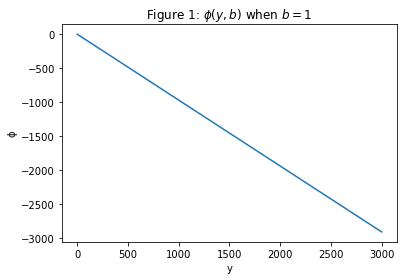

In [25]:
# fig = go.Figure(data=[go.Surface(z=ψ[10,:,:])])

# fig.update_layout(title='Mt Bruno Elevation', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))

# fig.show()

plt.figure()
plt.plot(y_grid, ψ[199,:])
plt.title(r'Figure 1: $\phi(y,b)$ when $b=1$ ')
plt.xlabel('y')
plt.ylabel('ϕ')
# plt.savefig('fig_1.pdf')

# plt.figure()
# plt.plot(y_grid, ψ[10,:])
# plt.title(r'Figure 2: $\phi(y,b,z_2)$ when $z_2=1.$, $b=0.01$ ')
# plt.xlabel('y')
# plt.ylabel('ϕ')
# # plt.savefig('fig_2.pdf')

In [17]:
Δ_b = b_grid[1] - b_grid[0]
Δ_y = y_grid[1] - y_grid[0]
(b_mat, y_mat) = np.meshgrid(b_grid, y_grid, indexing = 'ij')
stateSpace = np.hstack([b_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
# v0 = -δ*η*y_mat
v0 = ψ

v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

e = b_mat*δ*η / (1e-4-v0_dy)
e

array([[3.29192314e-05, 1.86099391e-05, 9.94027197e-06, ...,
        1.07713845e-07, 1.07170139e-07, 1.06900320e-07],
       [3.29238768e-05, 1.86116602e-05, 9.94083567e-06, ...,
        1.07713918e-07, 1.07170237e-07, 1.06900440e-07],
       [3.29262058e-05, 1.86125231e-05, 9.94111826e-06, ...,
        1.07713955e-07, 1.07170286e-07, 1.06900499e-07],
       ...,
       [3.29330791e-05, 1.86150690e-05, 9.94195200e-06, ...,
        1.07714065e-07, 1.07170432e-07, 1.06900677e-07],
       [3.29330798e-05, 1.86150693e-05, 9.94195208e-06, ...,
        1.07714065e-07, 1.07170432e-07, 1.06900677e-07],
       [3.29330805e-05, 1.86150695e-05, 9.94195217e-06, ...,
        1.07714065e-07, 1.07170432e-07, 1.06900677e-07]])

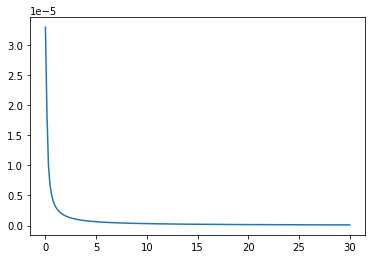

In [19]:
plt.plot(y_grid, e[199,:])